In [1]:
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
train = pd.read_csv('./data/H1_cleaned.csv')
test = pd.read_csv('./data/H2_cleaned.csv')

In [3]:
train['is_canceled'].value_counts()

0    23720
1     8697
Name: is_canceled, dtype: int64

- As you can see, the cancelled cases is very small compared to booked cases
- This can be a problem, we'll look later

In [4]:
test['is_canceled'].value_counts()

0    43137
1    30133
Name: is_canceled, dtype: int64

### Feature Engineering

#### Label Encoder

In [5]:
df_le = train.copy()
le = LabelEncoder()

categoricals = [
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
]

for col in categoricals:
    df_le[col] = le.fit_transform(df_le[col])

#### Correlation

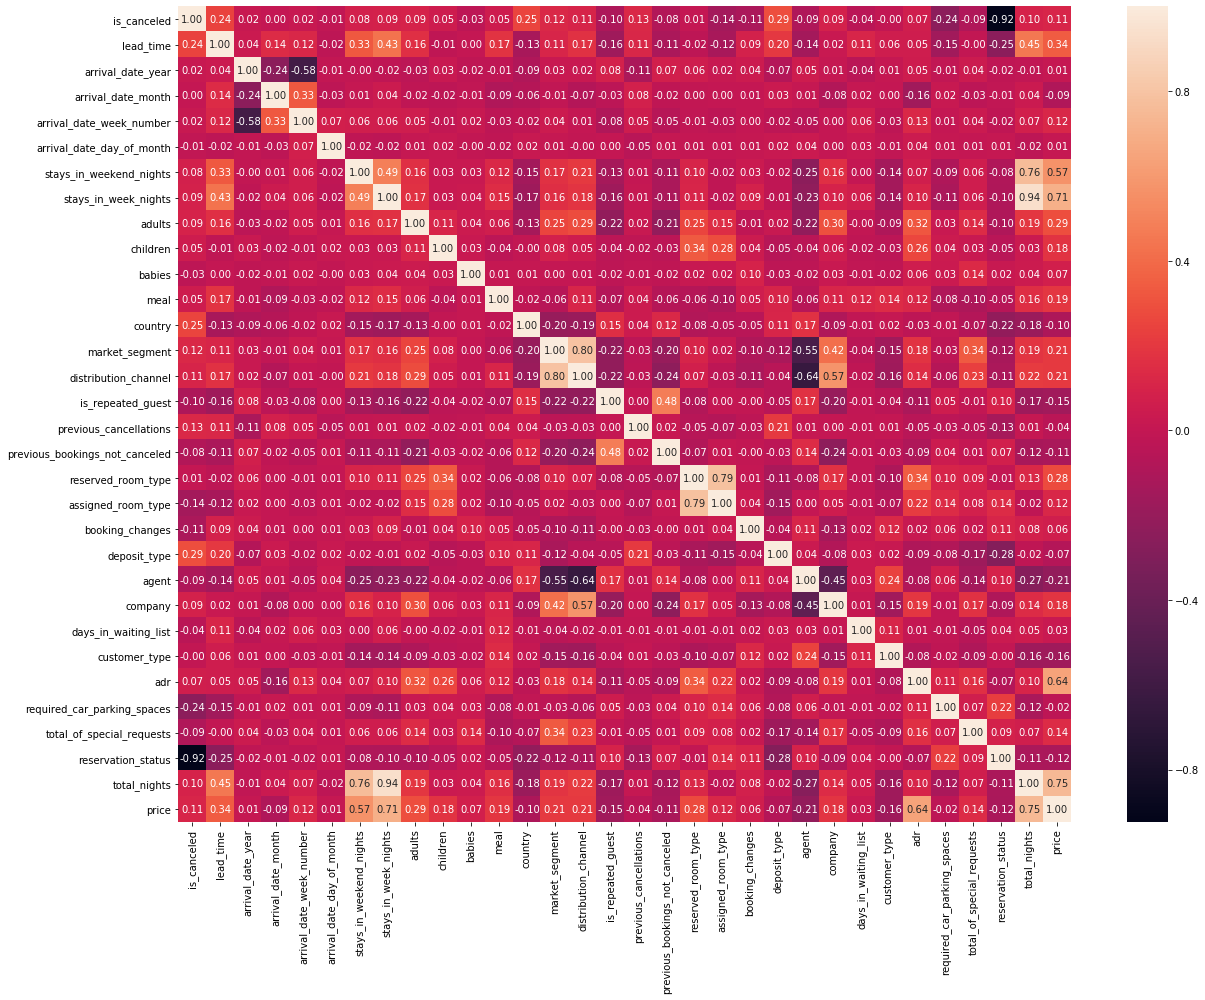

In [9]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_le.corr(), annot=True, fmt='.2f');

- There is high correlation between `reservation_status` and `is_canceled`
- And in the same, there is high correlation between `total_nights` and `stays_in_week_nights`
- And last one, between `total_nights` and `stays_in_weekend_nights`
- So, drop the `reservation_status` and `total_nights`
- And drop the `reservation_status_date` because of related between `reservation_status`

In [7]:
columns = [
    'reservation_status_date',
    'total_nights',
    'reservation_status',
]

train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)
df_le = df_le.drop(columns, axis=1)

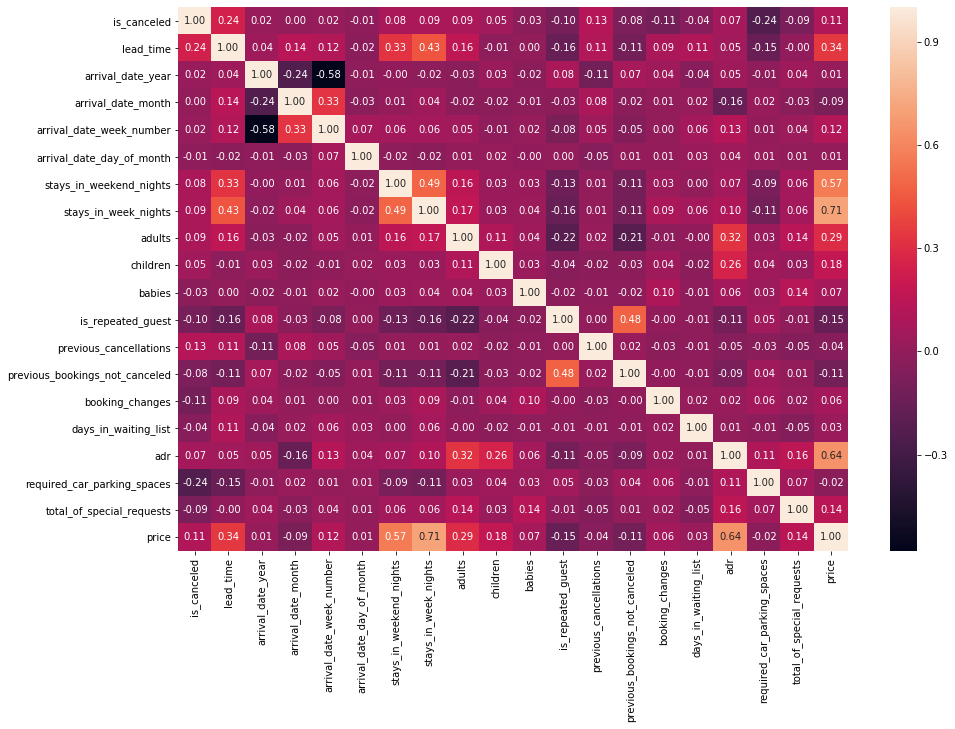

In [8]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_le.drop(drop_cols, axis=1).corr(), annot=True, fmt='.2f');

#### Dummy Variables vs Label Encoder

In [9]:
new_categoricals = [col for col in categoricals if col in train.columns]
df_hot = pd.get_dummies(data=train, columns=new_categoricals)
test_hot = pd.get_dummies(data=test, columns=new_categoricals)

In [10]:
X_hot = df_hot.drop('is_canceled', axis=1)
X_le = df_le.drop('is_canceled', axis=1)
y = train['is_canceled']

#### First Glance

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_hot, y, test_size=.2, random_state=42)

log = LogisticRegression().fit(X_train, y_train)
y_pred = log.predict(X_test)

In [12]:
accuracy_score(y_test, y_pred)

0.8584207279457126

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4740
           1       0.79      0.65      0.71      1744

    accuracy                           0.86      6484
   macro avg       0.83      0.79      0.81      6484
weighted avg       0.85      0.86      0.85      6484



- Accuracy score is very good but,
- As you can see, the prediction rate of cancelled bookings is lower
- Therefore, we'll increase the cancelled booking samples or decrease the booked booking samples

##### Feature Elimination

In [14]:
def select(X):
    selects = []
    
    selector = SelectKBest(chi2, k='all').fit(X, y)
    scores = selector.scores_
        
    q3 = np.quantile(scores, 0.75)
    q1 = np.quantile(scores, 0.25)
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr

    for col, val in zip(X.columns, scores):
        cond1 = val > threshold
        cond2 = col in test_hot.columns or col in test.columns
        
        if cond1 and cond2:
            if col not in test_hot.columns:
                test_hot.loc[:, col] = 0
            selects.append(col)
        
    return selects

In [15]:
selects_hot = select(X_hot)
selects_le = select(X_le)

In [16]:
def compare():
    for is_le in [True, False]:
        method = 'label encoder'
        
        if is_le:
            selected = df_le[selects_le + ['is_canceled']]
        else:
            selected = df_hot[selects_hot + ['is_canceled']]
            method = 'dummy variables'
        
        # separate majority and minority classes
        major = selected[selected['is_canceled'] == 0]
        minor = selected[selected['is_canceled'] == 1]

        # downsample majority class
        downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

        # combine minority class with downsampled majority class
        df_new = pd.concat([downsampled, minor])
    
        X = df_new.drop('is_canceled', axis=1)
        y = df_new['is_canceled']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

        log = LogisticRegression().fit(X_train, y_train)
        y_pred = log.predict(X_test)

        print(f'Accuracy for {method}: {accuracy_score(y_test, y_pred)}')
        print(f'Classification report for {method}:\n{classification_report(y_test, y_pred)}')

In [17]:
compare()

Accuracy for label encoder: 0.6901408450704225
Classification report for label encoder:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1739
           1       0.69      0.69      0.69      1740

    accuracy                           0.69      3479
   macro avg       0.69      0.69      0.69      3479
weighted avg       0.69      0.69      0.69      3479

Accuracy for dummy variables: 0.8212129922391492
Classification report for dummy variables:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1739
           1       0.81      0.83      0.82      1740

    accuracy                           0.82      3479
   macro avg       0.82      0.82      0.82      3479
weighted avg       0.82      0.82      0.82      3479



In [18]:
last = test_hot[selects_hot + ['is_canceled']]

X_last = last.drop('is_canceled', axis=1)
y_last = last['is_canceled']

In [19]:
selected = df_hot[selects_hot + ['is_canceled']]

In [20]:
# separate majority and minority classes
major = selected[selected['is_canceled'] == 0]
minor = selected[selected['is_canceled'] == 1]

# downsample majority class
downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

# combine minority class with downsampled majority class
df_new = pd.concat([downsampled, minor])

# display new class counts
df_new['is_canceled'].value_counts()

1    8697
0    8697
Name: is_canceled, dtype: int64

In [21]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

In [22]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Modelling

In [24]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'./images/{name}_{part}.png')
        plt.show()

In [25]:
report = Report(X_test, y_test)

#### Logistic Regression

In [26]:
log = LogisticRegression().fit(X_train, y_train)

Accuracy score:

0.8212129922391492

Confusion Matrix:

[[1406  333]
 [ 289 1451]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1739
           1       0.81      0.83      0.82      1740

    accuracy                           0.82      3479
   macro avg       0.82      0.82      0.82      3479
weighted avg       0.82      0.82      0.82      3479



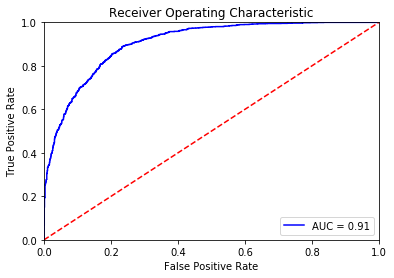

In [27]:
report.metrics(log)
report.plot_roc_curve(log)

In [28]:
cross_val_score(log, X_test, y_test, cv=10).mean()

0.8163271390241478

#### Naive Bayes

In [29]:
nb = GaussianNB().fit(X_train, y_train)

Accuracy score:

0.7579764300086231

Confusion Matrix:

[[1271  468]
 [ 374 1366]]

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1739
           1       0.74      0.79      0.76      1740

    accuracy                           0.76      3479
   macro avg       0.76      0.76      0.76      3479
weighted avg       0.76      0.76      0.76      3479



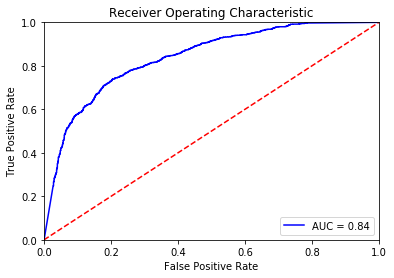

In [30]:
report.metrics(nb)
report.plot_roc_curve(nb)

In [31]:
cross_val_score(nb, X_test, y_test, cv=10).mean()

0.7576940276259565

#### KNN

In [32]:
knn = KNeighborsClassifier().fit(X_train, y_train)

In [33]:
knn = KNeighborsClassifier().fit(X_train, y_train)

Accuracy score:

0.6815176774935326

Confusion Matrix:

[[1162  577]
 [ 531 1209]]

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1739
           1       0.68      0.69      0.69      1740

    accuracy                           0.68      3479
   macro avg       0.68      0.68      0.68      3479
weighted avg       0.68      0.68      0.68      3479



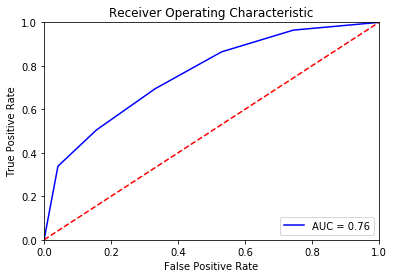

In [34]:
report.metrics(knn)
report.plot_roc_curve(knn)

In [35]:
cross_val_score(knn, X_test, y_test, cv=10).mean()

0.6438470966245984

- Model Tuning

In [36]:
knn_params = {'n_neighbors': range(1, 11)}

In [37]:
params = {
    'estimator': knn,
    'param_grid': knn_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
knn_cv = GridSearchCV(**params)

In [38]:
_ = knn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished


In [39]:
knn_cv.best_params_

{'n_neighbors': 1}

In [40]:
knn = KNeighborsClassifier(**knn_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.7065248634665133

Confusion Matrix:

[[1193  546]
 [ 475 1265]]

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.69      0.70      1739
           1       0.70      0.73      0.71      1740

    accuracy                           0.71      3479
   macro avg       0.71      0.71      0.71      3479
weighted avg       0.71      0.71      0.71      3479



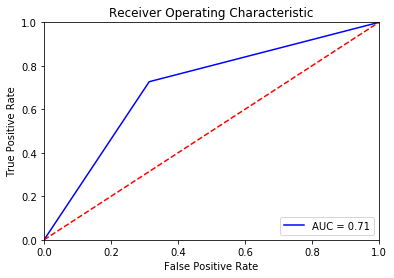

In [41]:
report.metrics(knn)
report.plot_roc_curve(knn)

In [42]:
cross_val_score(knn, X_test, y_test, cv=10).mean()

0.6513274702706283

#### Decision Tree

In [43]:
cart = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

Accuracy score:

0.7605633802816901

Confusion Matrix:

[[1101  638]
 [ 195 1545]]

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.63      0.73      1739
           1       0.71      0.89      0.79      1740

    accuracy                           0.76      3479
   macro avg       0.78      0.76      0.76      3479
weighted avg       0.78      0.76      0.76      3479



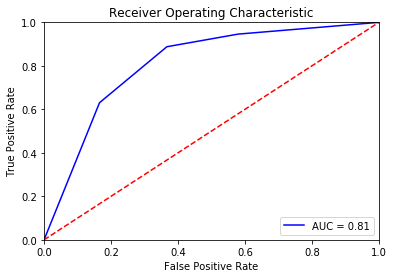

In [44]:
report.metrics(cart)
report.plot_roc_curve(cart)

In [45]:
cross_val_score(cart, X_test, y_test, cv=10).mean()

0.7191700619430919

- Model Tuning

In [46]:
cart_params = {
    'max_depth': range(5, 25, 5),
    'min_samples_split' : range(2, 50), 
}

In [47]:
params = {
    'estimator': cart,
    'param_grid': cart_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
cart_cv = GridSearchCV(**params)

In [48]:
_ = cart_cv.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   37.2s finished


In [49]:
cart_cv.best_params_

{'max_depth': 5, 'min_samples_split': 2}

In [50]:
cart = DecisionTreeClassifier(**cart_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8436332279390629

Confusion Matrix:

[[1341  398]
 [ 146 1594]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1739
           1       0.80      0.92      0.85      1740

    accuracy                           0.84      3479
   macro avg       0.85      0.84      0.84      3479
weighted avg       0.85      0.84      0.84      3479



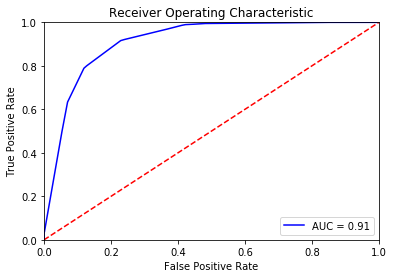

In [51]:
report.metrics(cart)
report.plot_roc_curve(cart)

In [52]:
cross_val_score(cart, X_test, y_test, cv=10).mean()

0.835005299943688

#### Random Forests

In [53]:
rf = RandomForestClassifier().fit(X_train, y_train)

Accuracy score:

0.870939925265881

Confusion Matrix:

[[1526  213]
 [ 236 1504]]

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1739
           1       0.88      0.86      0.87      1740

    accuracy                           0.87      3479
   macro avg       0.87      0.87      0.87      3479
weighted avg       0.87      0.87      0.87      3479



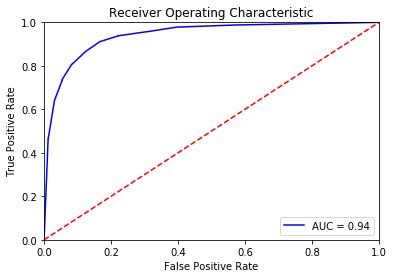

In [54]:
report.metrics(rf)
report.plot_roc_curve(rf)

In [55]:
cross_val_score(rf, X_test, y_test, cv=10).mean()

0.8493813971976547

- Model Tuning

In [56]:
rf_params = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [2, 3, 5],
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [5, 10, 15],
}

In [57]:
params = {
    'estimator': rf,
    'param_grid': rf_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
rf_cv = GridSearchCV(**params)

In [58]:
_ = rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 11.5min finished


In [59]:
rf_cv.best_params_

{'max_depth': 20,
 'max_features': 5,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [60]:
rf = RandomForestClassifier(**rf_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8792756539235412

Confusion Matrix:

[[1497  242]
 [ 178 1562]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1739
           1       0.87      0.90      0.88      1740

    accuracy                           0.88      3479
   macro avg       0.88      0.88      0.88      3479
weighted avg       0.88      0.88      0.88      3479



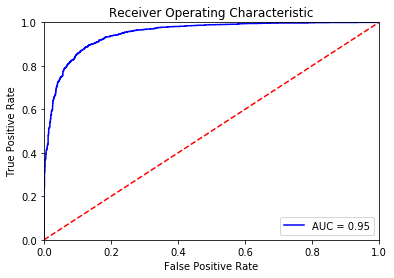

In [61]:
report.metrics(rf)
report.plot_roc_curve(rf, save=True)

In [62]:
cross_val_score(rf, X_test, y_test, cv=10).mean()

0.8657615356586836

#### Gradient Boosting Machines

In [63]:
gbm = GradientBoostingClassifier().fit(X_train, y_train)

Accuracy score:

0.8643288301235987

Confusion Matrix:

[[1434  305]
 [ 167 1573]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1739
           1       0.84      0.90      0.87      1740

    accuracy                           0.86      3479
   macro avg       0.87      0.86      0.86      3479
weighted avg       0.87      0.86      0.86      3479



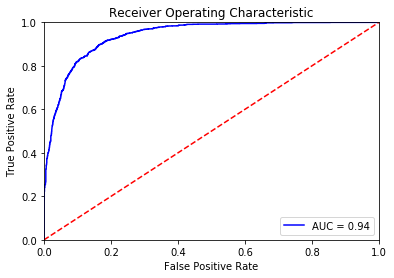

In [64]:
report.metrics(gbm)
report.plot_roc_curve(gbm)

In [65]:
cross_val_score(gbm, X_test, y_test, cv=10).mean()

0.8585710026830965

- Model Tuning

In [66]:
gbm_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
}

In [67]:
params = {
    'estimator': gbm,
    'param_grid': gbm_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
gbm_cv = GridSearchCV(**params)

In [68]:
_ = gbm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 51.3min finished


In [69]:
gbm_cv.best_params_

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

In [70]:
gbm = GradientBoostingClassifier(**gbm_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8855993101465939

Confusion Matrix:

[[1509  230]
 [ 168 1572]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1739
           1       0.87      0.90      0.89      1740

    accuracy                           0.89      3479
   macro avg       0.89      0.89      0.89      3479
weighted avg       0.89      0.89      0.89      3479



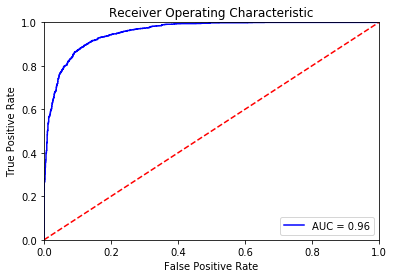

In [71]:
report.metrics(gbm)
report.plot_roc_curve(gbm, save=True)

In [72]:
cross_val_score(gbm, X_test, y_test, cv=10).mean()

0.857424061744344

#### XGBoost

In [73]:
xgb = XGBClassifier().fit(X_train, y_train)

Accuracy score:

0.8631790744466801

Confusion Matrix:

[[1427  312]
 [ 164 1576]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1739
           1       0.83      0.91      0.87      1740

    accuracy                           0.86      3479
   macro avg       0.87      0.86      0.86      3479
weighted avg       0.87      0.86      0.86      3479



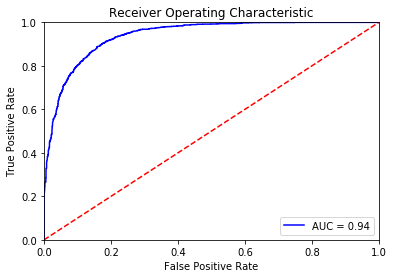

In [74]:
report.metrics(xgb)
report.plot_roc_curve(xgb)

In [75]:
cross_val_score(xgb, X_test, y_test, cv=10).mean()

0.8597245685514592

- Model Tuning

In [76]:
xgb_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
}

In [77]:
params = {
    'estimator': xgb,
    'param_grid': xgb_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
xgb_cv = GridSearchCV(**params)

In [78]:
_ = xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 44.1min finished


In [79]:
xgb_cv.best_params_

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

In [80]:
xgb = XGBClassifier(**xgb_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8878988215004312

Confusion Matrix:

[[1509  230]
 [ 160 1580]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1739
           1       0.87      0.91      0.89      1740

    accuracy                           0.89      3479
   macro avg       0.89      0.89      0.89      3479
weighted avg       0.89      0.89      0.89      3479



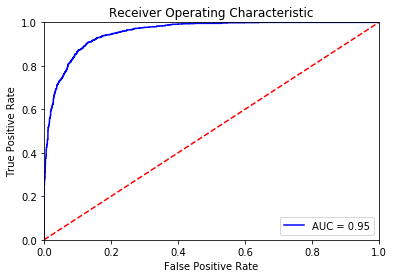

In [81]:
report.metrics(xgb)
report.plot_roc_curve(xgb, save=True)

In [82]:
cross_val_score(xgb, X_test, y_test, cv=10).mean()

0.8588567027725331

#### Light GBM

In [83]:
lgbm = LGBMClassifier().fit(X_train, y_train)

Accuracy score:

0.8855993101465939

Confusion Matrix:

[[1504  235]
 [ 163 1577]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1739
           1       0.87      0.91      0.89      1740

    accuracy                           0.89      3479
   macro avg       0.89      0.89      0.89      3479
weighted avg       0.89      0.89      0.89      3479



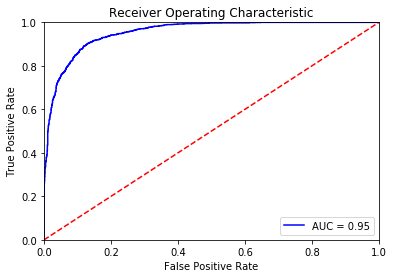

In [84]:
report.metrics(lgbm)
report.plot_roc_curve(lgbm)

In [85]:
cross_val_score(lgbm, X_test, y_test, cv=10).mean()

0.8663337639537578

- Model Tuning

In [86]:
lgbm_params = {
    'n_estimators': [100, 500, 1000, 2000],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.1, 0.01, 0.02, 0.05],
    'min_child_samples': [5, 10, 20],
}

In [87]:
params = {
    'estimator': lgbm,
    'param_grid': lgbm_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
lgbm_cv = GridSearchCV(**params)

In [88]:
_ = lgbm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 46.5min finished


In [89]:
lgbm_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_samples': 10,
 'n_estimators': 100,
 'subsample': 0.6}

In [90]:
lgbm = LGBMClassifier(**lgbm_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8433457890198333

Confusion Matrix:

[[1327  412]
 [ 133 1607]]

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1739
           1       0.80      0.92      0.86      1740

    accuracy                           0.84      3479
   macro avg       0.85      0.84      0.84      3479
weighted avg       0.85      0.84      0.84      3479



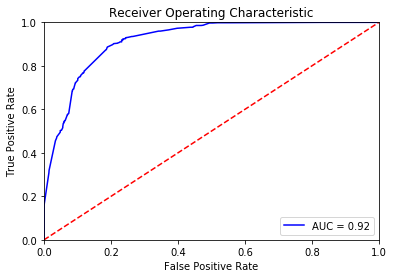

In [91]:
report.metrics(lgbm)
report.plot_roc_curve(lgbm, save=True)

In [92]:
cross_val_score(lgbm, X_test, y_test, cv=10).mean()

0.8416161515783894

### Final

In [93]:
Xtr_last, Xte_last, ytr_last, yte_last = train_test_split(X_last, y_last, test_size=.2, random_state=42)

RandomForestClassifier
Accuracy score:

0.8584004367408217

Confusion Matrix:

[[8216  484]
 [1591 4363]]

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      8700
           1       0.90      0.73      0.81      5954

    accuracy                           0.86     14654
   macro avg       0.87      0.84      0.85     14654
weighted avg       0.86      0.86      0.86     14654



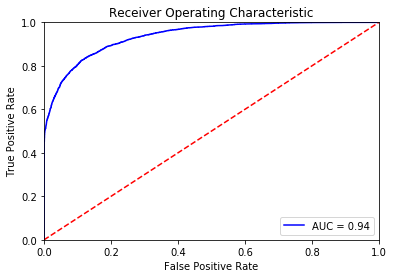

GradientBoostingClassifier
Accuracy score:

0.8809881261089122

Confusion Matrix:

[[7954  746]
 [ 998 4956]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      8700
           1       0.87      0.83      0.85      5954

    accuracy                           0.88     14654
   macro avg       0.88      0.87      0.88     14654
weighted avg       0.88      0.88      0.88     14654



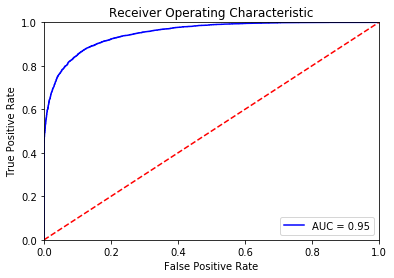

XGBClassifier
Accuracy score:

0.8637914562576771

Confusion Matrix:

[[7943  757]
 [1239 4715]]

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8700
           1       0.86      0.79      0.83      5954

    accuracy                           0.86     14654
   macro avg       0.86      0.85      0.86     14654
weighted avg       0.86      0.86      0.86     14654



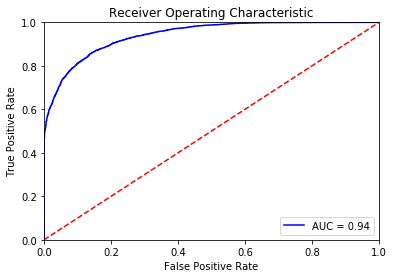

LGBMClassifier
Accuracy score:

0.8157499658796233

Confusion Matrix:

[[8055  645]
 [2055 3899]]

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      8700
           1       0.86      0.65      0.74      5954

    accuracy                           0.82     14654
   macro avg       0.83      0.79      0.80     14654
weighted avg       0.82      0.82      0.81     14654



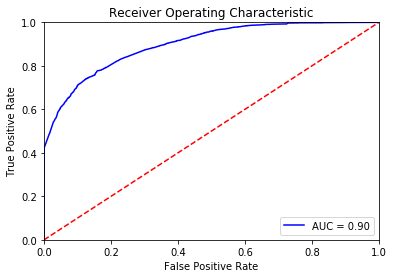

In [94]:
report = Report(Xte_last, yte_last)

params = {
    'RandomForestClassifier': {
        'max_depth': 20,
        'max_features': 5,
        'min_samples_split': 5,
        'n_estimators': 1000,
    },
    'GradientBoostingClassifier': {
        'max_depth': 10, 
        'min_samples_split': 10, 
        'n_estimators': 500,
    },
    'XGBClassifier': {
        'max_depth': 10, 
        'min_samples_split': 2, 
        'n_estimators': 100,
    },
    'LGBMClassifier': {
        'learning_rate': 0.02,
        'max_depth': 5,
        'min_child_samples': 20,
        'n_estimators': 100,
        'subsample': 0.6,
    }
}

rf = RandomForestClassifier(**params['RandomForestClassifier'])
gbm = GradientBoostingClassifier(**params['GradientBoostingClassifier'])
xgb = XGBClassifier(**params['XGBClassifier'])
lgbm = LGBMClassifier(**params['LGBMClassifier'])

for model in [rf, gbm, xgb, lgbm]:
    print(model.__class__.__name__)
    _ = model.fit(Xtr_last, ytr_last)
    report.metrics(model)
    report.plot_roc_curve(model, part='h2', save=True)